In [122]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

In [153]:
# read in dataset
df = pd.read_csv("/Users/max/Desktop/savant_data.csv")
print(df.shape)

(13231, 94)


In [154]:
# EDA part
# select columns that are used to predict the release_speed based on pitch_type
n_df = df[["pitch_type", "release_speed", "release_pos_x", "release_pos_y", 
           "release_pos_z", "stand", "p_throws", "vx0", "vy0", "vz0", 
           "ax", "ay", "az", "release_spin_rate"]]

# replace the null/NaN/?/none with NaN/Unknown
n_df = n_df.replace('?', np.nan)

n_df['pitch_type'] = n_df['pitch_type'].fillna('Unknown')

# check the shape of data frame
print(n_df.shape)

# check the types of each feature
print(n_df.dtypes)
print(n_df.head())


(13231, 14)
pitch_type            object
release_speed        float64
release_pos_x        float64
release_pos_y        float64
release_pos_z        float64
stand                 object
p_throws              object
vx0                  float64
vy0                  float64
vz0                  float64
ax                   float64
ay                   float64
az                   float64
release_spin_rate    float64
dtype: object
  pitch_type  release_speed  release_pos_x  release_pos_y  release_pos_z  \
0         FS           84.4           1.56          53.98           6.29   
1         FF           89.2           1.76          54.08           6.24   
2         SL           86.3           1.67          54.06           6.23   
3         CU           73.1           1.40          53.82           6.46   
4         SL           87.1           1.71          53.95           6.19   

  stand p_throws       vx0         vy0       vz0         ax         ay  \
0     R        L -5.128745 -122.58731

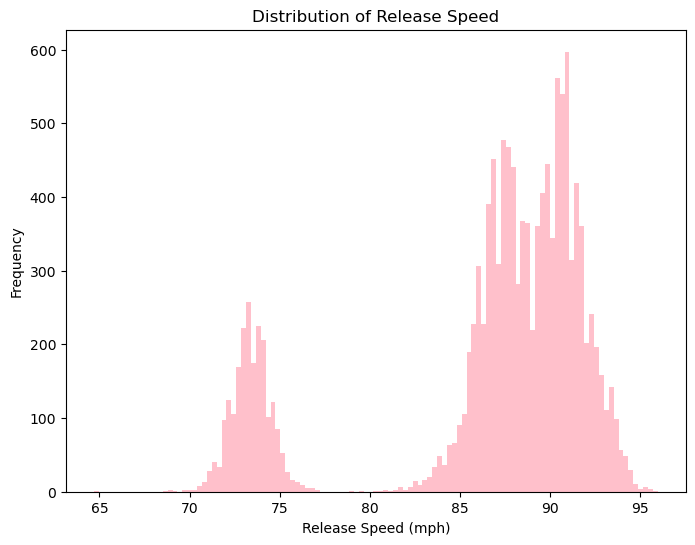

In [189]:
# distribution of target variable
plt.figure(figsize=(8,6))
plt.hist(n_df['release_speed'],bins = int(np.sqrt(n_df.shape[0])), color='pink')
plt.title('Distribution of Release Speed')
plt.xlabel('Release Speed (mph)')
plt.ylabel('Frequency')
plt.show()


  pitch_type  percentage
0         FF   40.616733
1         SL   40.594059
2         CU   16.264833
3    Unknown    1.322651
4         CH    0.808707
5         SI    0.332552
6         FS    0.052906
7         FA    0.007558


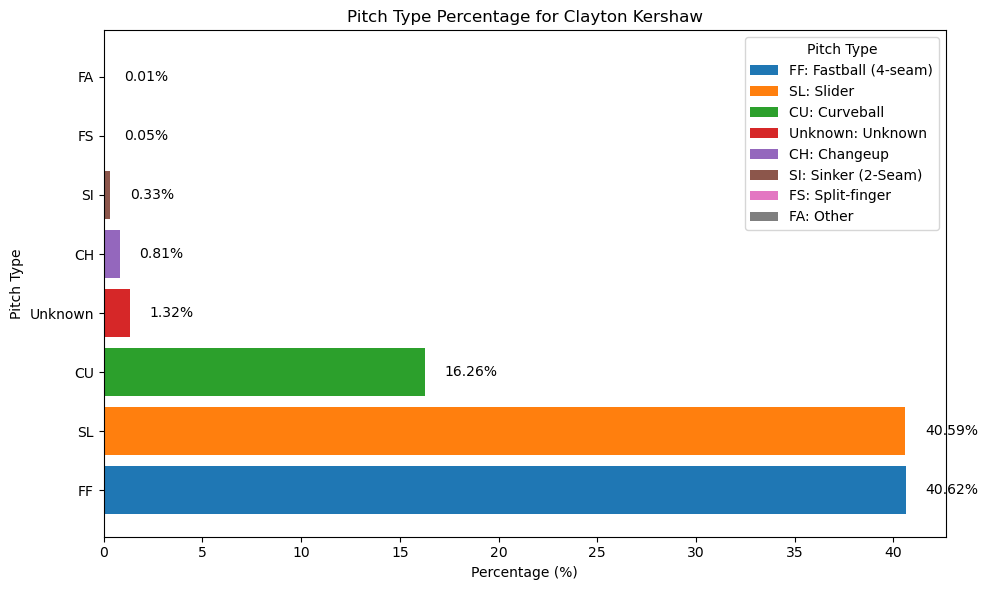

In [155]:
# compute the percentage of each pitch type among the total number of pitchs during 2017-2023 exclusive 2020
pitch_type_counts = n_df['pitch_type'].value_counts(normalize=True) * 100

pitch_type_percentages = pd.DataFrame({
    'pitch_type': pitch_type_counts.index,
    'percentage': pitch_type_counts.values
})

print(pitch_type_percentages)

plt.figure(figsize=(10, 6))

for i, row in pitch_type_percentages.iterrows():
    plt.barh(row['pitch_type'], row['percentage'], label=row['pitch_type'])
    plt.text(row['percentage'] + 1, i, f"{row['percentage']:.2f}%", va='center')


plt.title('Pitch Type Percentage for Clayton Kershaw')
plt.xlabel('Percentage (%)')
plt.ylabel('Pitch Type')

# full name of each pitch type
pitch_type = {
    'FF': 'Fastball (4-seam)',
    'SL': 'Slider',
    'CU': 'Curveball',
    'Unknown': 'Unknown',
    'CH': 'Changeup',
    'SI': 'Sinker (2-Seam)',
    'FS': 'Split-finger',
    'FA': 'Other'
}
plt.legend([f'{key}: {value}' for key, value in pitch_type.items()], title='Pitch Type', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

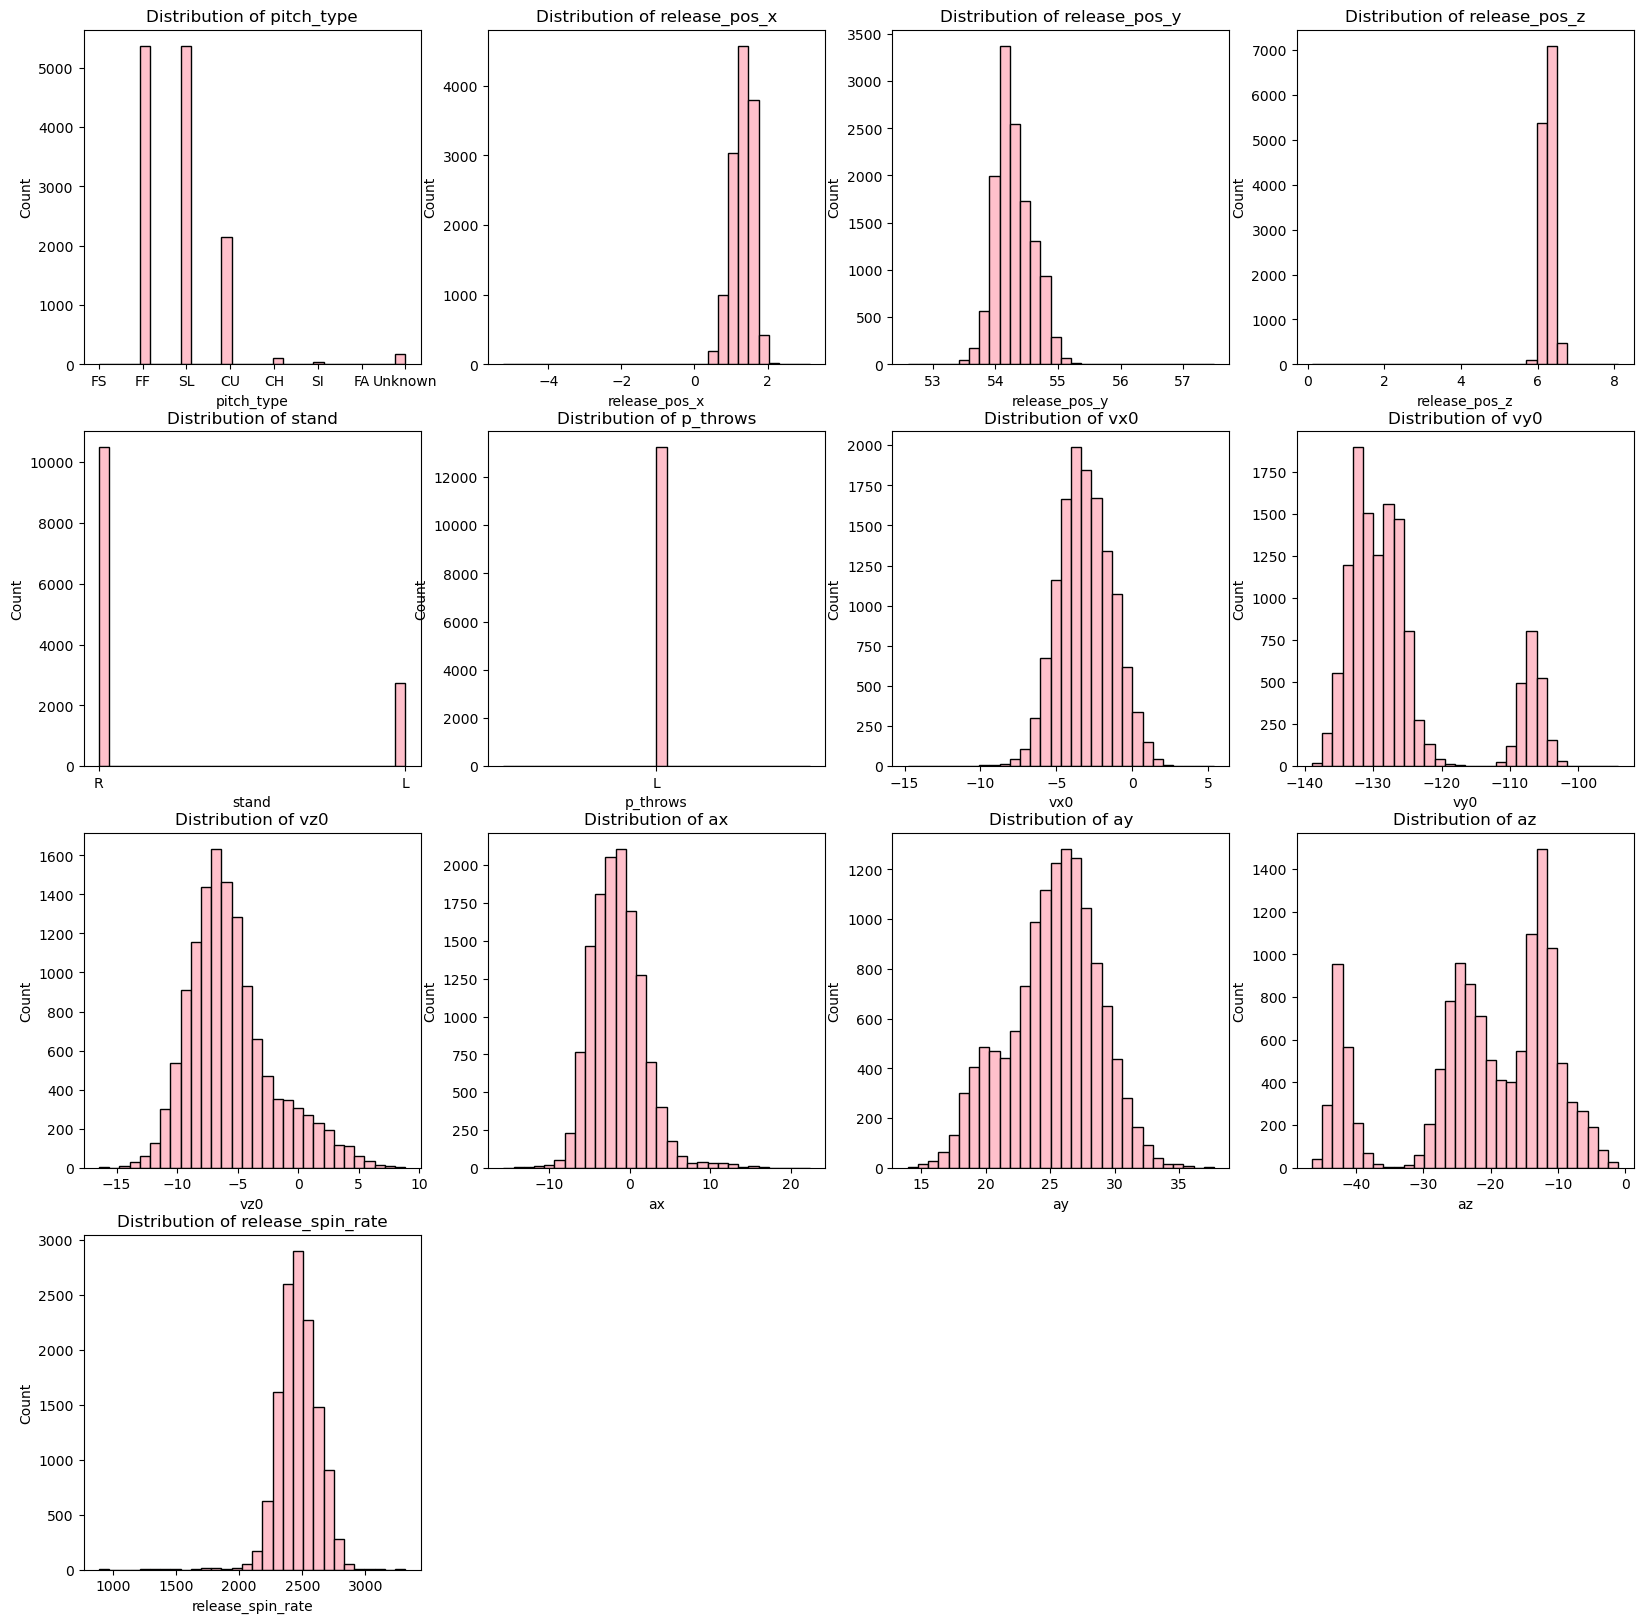

In [168]:
only_features = df[["pitch_type", "release_pos_x", "release_pos_y", 
           "release_pos_z", "stand", "p_throws", "vx0", "vy0", "vz0", 
           "ax", "ay", "az", "release_spin_rate"]]

plt.figure(figsize=(20, 20))

for i, feature in enumerate(only_features):
    plt.subplot(4, 4, i+1)
    plt.hist(n_df[feature], bins=30, color='pink', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.show()

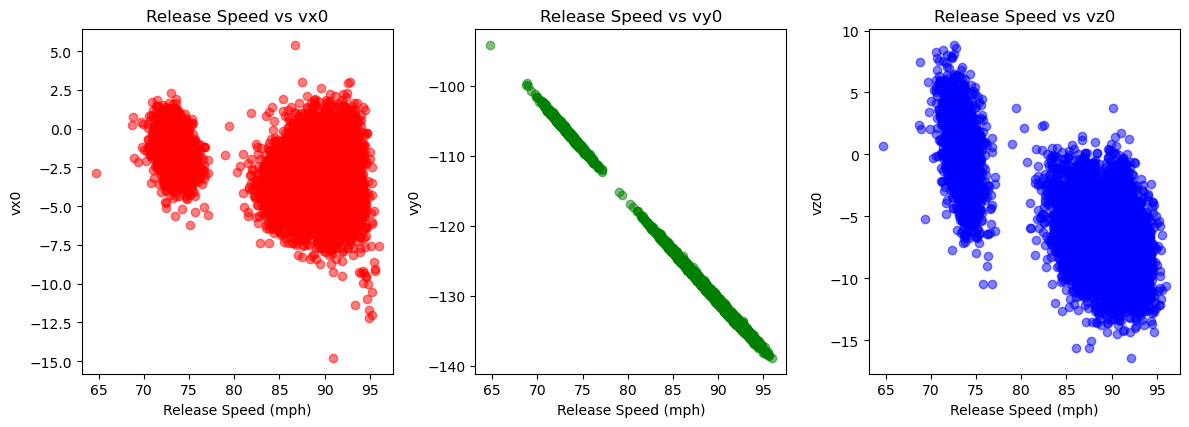

In [188]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1)
plt.scatter(n_df['release_speed'], n_df['vx0'], alpha=0.5, c='r')
plt.title('Release Speed vs vx0')
plt.xlabel('Release Speed (mph)')
plt.ylabel('vx0')

plt.subplot(3, 3, 2)
plt.scatter(n_df['release_speed'], n_df['vy0'], alpha=0.5, c='g')
plt.title('Release Speed vs vy0')
plt.xlabel('Release Speed (mph)')
plt.ylabel('vy0')

plt.subplot(3, 3, 3)
plt.scatter(n_df['release_speed'], n_df['vz0'], alpha=0.5, c='b')
plt.title('Release Speed vs vz0')
plt.xlabel('Release Speed (mph)')
plt.ylabel('vz0')

plt.tight_layout()
plt.show()

<Figure size 600x600 with 0 Axes>

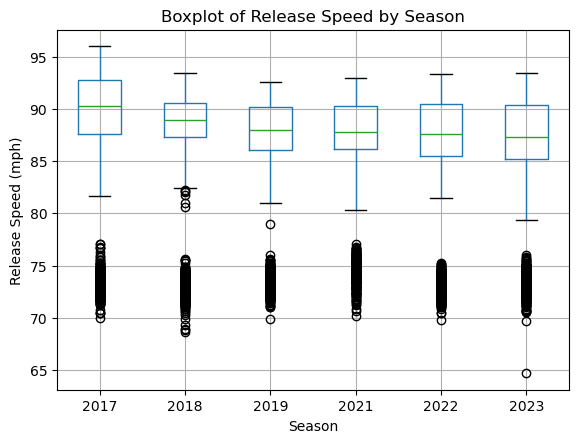

In [194]:
df['game_date'] = pd.to_datetime(df['game_date'])

df['season'] = df['game_date'].dt.year

plt.figure(figsize=(6, 6))
df.boxplot(column='release_speed', by='season')
plt.title('Boxplot of Release Speed by Season')
plt.suptitle('')
plt.xlabel('Season')
plt.ylabel('Release Speed (mph)')
plt.show()

In [173]:
# split part
# This is an non iid dataset and is based on pitch type.
# use GroupShuffleSplit to make sure the points from the same group are in the same set and split the test set.
# use GroupKFold to split the other two sets, train set and test(validation) set. I choose 3 folds to do this splitting, 
# since the data has 8 groups. 3 is a reasonable number for that.
y = n_df['release_speed']
pitch_type = n_df['pitch_type']
X = n_df.drop(columns=['release_speed'])

      
splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state = 42)

for i_other,i_test in splitter.split(X, y, pitch_type):
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], pitch_type.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], pitch_type.iloc[i_test]

print(pd.unique(groups_other))
print(pd.unique(groups_test))

kf = GroupKFold(n_splits = 3)

# the first fold : train and test sets
for fold, (train_index, val_index) in enumerate(kf.split(X_other, y_other, groups_other), start=1):
    if fold == 1:
        X_train_1, y_train_1 = X_other.iloc[train_index], y_other.iloc[train_index]
        X_val_1, y_val_1 = X_other.iloc[val_index], y_other.iloc[val_index]
        break
print('the first fold : train and test sets ')
print(X_train_1.head())
print(X_val_1.head())

# the second fold : train and test sets
for fold, (train_index, val_index) in enumerate(kf.split(X_other, y_other, groups_other), start=1):
    if fold == 2:
        X_train_2, y_train_2 = X_other.iloc[train_index], y_other.iloc[train_index]
        X_val_2, y_val_2 = X_other.iloc[val_index], y_other.iloc[val_index]
        break
print('the second fold : train and test sets')
print(X_train_2.head())
print(X_val_2.head())

# the third fold : train and test sets
for fold, (train_index, val_index) in enumerate(kf.split(X_other, y_other, groups_other), start=1):
    if fold == 3:
        X_train_3, y_train_3 = X_other.iloc[train_index], y_other.iloc[train_index]
        X_val_3, y_val_3 = X_other.iloc[val_index], y_other.iloc[val_index]
        break
print('the third fold : train and test sets')
print(X_train_3.head())
print(X_val_3.head())


['FS' 'FF' 'SL' 'CH' 'FA' 'Unknown']
['CU' 'SI']
the first fold : train and test sets 
  pitch_type  release_pos_x  release_pos_y  release_pos_z stand p_throws  \
0         FS           1.56          53.98           6.29     R        L   
2         SL           1.67          54.06           6.23     R        L   
4         SL           1.71          53.95           6.19     R        L   
7         SL           1.81          53.95           6.17     R        L   
8         SL           1.64          53.98           6.23     R        L   

        vx0         vy0       vz0         ax         ay         az  \
0 -5.128745 -122.587310 -7.625560  10.298196  24.294759 -17.866496   
2 -3.800005 -125.420932 -7.543265   2.213520  26.577980 -18.379731   
4 -5.795073 -126.413656 -8.940820  -1.664469  27.169733 -23.375621   
7 -5.473099 -126.356374 -6.750844  -3.545924  24.349186 -24.662480   
8 -5.768661 -125.680859 -7.422271  -2.029756  24.529948 -23.192594   

   release_spin_rate  
0           

In [181]:
# preprocess part
onehot_ftrs = ['pitch_type', 'stand', 'p_throws']
std_ftrs = ["release_pos_x", "release_pos_y", 
           "release_pos_z", "vx0", "vy0", "vz0", 
           "ax", "ay", "az", "release_spin_rate"]

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)]) 


# for the first fold
X_train_prep_1 = clf.fit_transform(X_train_1)
X_val_prep_1 = clf.transform(X_val_1)
print(X_train_prep_1.shape)
print(X_train_1.shape)
print('transformed X_train_1:', X_train_prep_1)
# only one test set
X_test_prep = clf.transform(X_test)

# for the second fold
X_train_prep_2 = clf.fit_transform(X_train_2)
X_val_prep_2 = clf.transform(X_val_2)
print(X_train_prep_2.shape)
print(X_train_2.shape)
print('transformed X_train_2:', X_train_prep_2)

## for the thrid fold
X_train_prep_3 = clf.fit_transform(X_train_3)
X_val_prep_3 = clf.transform(X_val_3)
print(X_train_prep_3.shape)
print(X_train_3.shape)
print('transformed X_train_3:', X_train_prep_3)


# missing value


(5661, 18)
(5661, 13)
transformed X_train_1: [[ 0.          0.          1.         ... -0.22123359  1.32358313
  -6.98389423]
 [ 0.          0.          0.         ...  0.90413128  1.18878512
  -0.67602105]
 [ 0.          0.          0.         ...  1.1957976  -0.12335506
  -0.59060194]
 ...
 [ 0.          0.          0.         ...  0.19314573  2.58294919
  -0.77458157]
 [ 0.          0.          0.         ...  1.0535963   1.41837847
  -0.29492038]
 [ 0.          0.          0.         ...  0.09968624  1.32391797
  -0.32777389]]
(5664, 18)
(5664, 13)
transformed X_train_2: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.51729240e+00
  -2.01929881e+00 -7.40821485e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  1.02565926e-01
  -9.97860359e-01 -7.99749382e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ... -1.17110698e-01
   2.47228316e-04 -8.16106969e-01]
 ...
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 ...  2.24470521e-01
   1.83245404e+00 -8.3246455